In [6]:
import SDR
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp
import copy
import imp
import DynamicRegression as DR

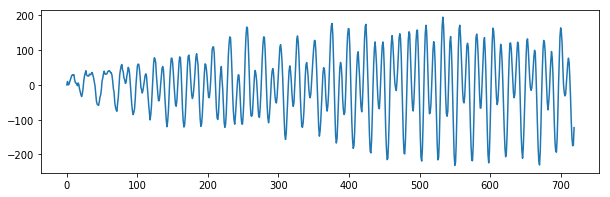

In [7]:
n_points=24*30
np.random.seed(324135)
freq_seasonal = {"harmonics":2, "period":24}

mod = sm.tsa.UnobservedComponents(np.zeros(n_points),
                                  "local linear trend",
                                 autoregressive=1,
                                 freq_seasonal=[freq_seasonal]
)
params = (0,0,0,10,10,.9)
coefs = mod.simulate(params=params,nsimulations=n_points,
                    initial_state=(0,0,0,0,0,0,0))
pd.Series(coefs).plot(figsize=(10,3))

Generate the exogenous covariates as a sequence of exponentially distributed random variables. The endogenous data is given by multiplying the exogenous covariates by the simulated regression coefficients and adding some noise white.

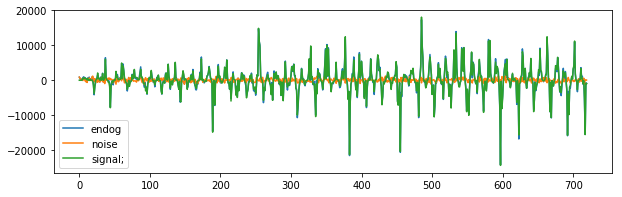

In [8]:
np.random.seed(125)
exog = np.random.exponential(30,n_points)
noise = np.random.normal(scale=np.var(exog)*.5,size=n_points)
signal = exog*coefs
endog = signal + noise
pd.DataFrame({"signal;":signal,"endog":endog,"noise":noise}).plot(figsize=(10,3))


In [9]:
imp.reload(DR)
freq_seasonal = {"harmonics":2, "period":24}
sdr = DR.DynamicRegression(
    endog,exog,exog_models={"irregular":True,
                            "stochastic_level":False,
                            "stochastic_trend":False,
                            "stochastic_freq_seasonal":
                            freq_seasonal,
                            "AR":1,"MA":0})

results = sdr.fit()

/home/alastair/git/DynamicRegression/DynamicRegression.py:539: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ssm.obs_cov[0, 0, 0] = obs_cov
/home/alastair/git/DynamicRegression/DynamicRegression.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  self.k_state_cov)] = state_cov_params
/home/alastair/git/DynamicRegression/DynamicRegression.py:549: ComplexWarning: Casting complex values to real discards the imaginary part
  1), 2)


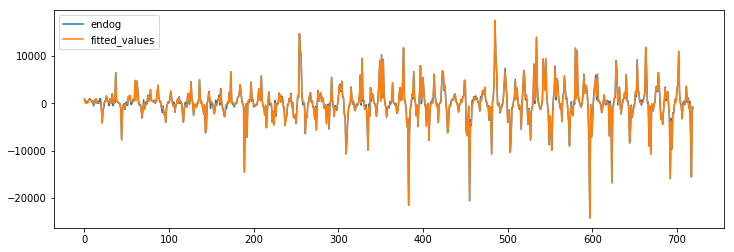

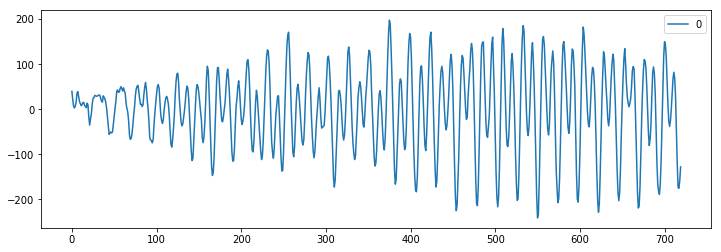

In [15]:
results.plot_dynamic_regression(which ="smoothed",figsize=(12,4))